In [10]:
from dataclasses import dataclass, field, asdict
from typing import List, Optional, Any, Dict, Union

import pandas as pd
import matplotlib.pyplot as plt

from pysolotools.core.models import Annotation, DataFactory, Frame
from pysolotools.stats.analyzers.base import StatsAnalyzer
from pysolotools.stats.handler import StatsHandler
from pysolotools.consumers import Solo

### Define dataclass for your Custom Labeler

In [2]:
@dataclass
class HumanMetadataLabel:
    instanceId: int
    age: str
    height: str
    weight: str
    sex: str
    ethnicity: str
    bodyMeshTag: str
    hairMeshTag: str
    faceVatTag: str
    primaryBlendVatTag: str
    secondaryBlendVatTag: str
    bodyMaterialTag: str
    faceMaterialTag: str
    eyeMaterialTag: str
    hairMaterialTag: str
    templateSkeleton: Optional[str]
    clothingTags: List[str]
    clothingMaterialTags: List[str]


@DataFactory.register("type.unity.com/unity.solo.HumanMetadataAnnotation")
@dataclass
class HumanMetadataAnnotation(Annotation):
    metadata: List[HumanMetadataLabel] = field(default_factory=list)

### Define your custom StatsAnalyzer

In [3]:

class HumanMetadataAnnotationAnalyzer(StatsAnalyzer):
    def __init__(self):
        self._res = None

    @staticmethod
    def _filter(frame: Frame) -> List[HumanMetadataAnnotation]:
        results = []

        for capture in frame.captures:
            results.extend(
                filter(
                    lambda k: isinstance(k, HumanMetadataAnnotation),
                    capture.annotations,
                )
            )
        return results[0]

    def analyze(self, frame: Frame = None, **kwargs: Any) -> pd.DataFrame:
        """
        Args:
            frame (Frame): metadata of one frame
        Returns:
        """
        human_metadata = HumanMetadataAnnotationAnalyzer._filter(frame=frame)
        human_metadata_stats = []
        for d in human_metadata.metadata:
            human_metadata_stats.append(asdict(d))
            
        df = pd.DataFrame.from_records(human_metadata_stats)

        return df

    def merge(self, frame_result: pd.DataFrame, **kwargs):
        """
        Merge computed stats values.
        Args:
            frame_result (list):  result of one frame.
        Returns:
        """
        if isinstance(self._res, pd.DataFrame):
            self._res = pd.concat([self._res, frame_result], ignore_index=True)
        else:
            self._res = frame_result
        self._res['height'] = self._res['height'].astype(float)
        self._res['weight'] = self._res['weight'].astype(float)

    def get_result(self) -> pd.DataFrame:
        return self._res

### Instantiate analyzer, handler and solo objects

In [4]:
solo = Solo("<SOLO-DATA-PATH>")
human_metadata_analyzer = HumanMetadataAnnotationAnalyzer()

In [5]:
handler = StatsHandler(solo)
res = handler.handle([human_metadata_analyzer])

DONE (t=0.00000s)


### Generate Plots

In [6]:
df = res["HumanMetadataAnnotationAnalyzer"]
df.head()

,instanceId,age,height,weight,sex,ethnicity,bodyMeshTag,hairMeshTag,faceVatTag,primaryBlendVatTag,secondaryBlendVatTag,bodyMaterialTag,faceMaterialTag,eyeMaterialTag,hairMaterialTag,templateSkeleton,clothingTags,clothingMaterialTags
0,45,Adult,0.951280,0.968923,Male,MiddleEastern,Mesh.01.0000.05.01.0000,Mesh.03.0002.05.0000,VAT.02.0000.05.01.02.02.99,VAT.01.0000.05.01.02.03.0000,VAT.01.0000.05.01.03.02.0000,Female Body Material,Head_0012,Eye Material,Mesh.03.0003.01.0000,None,"[Mesh.01.0001.05.01.0000, Mesh.03.0006.05.01.0...","[Single_Colour_Knit_2, Checkered_1, Shoe.0011]"
1,43,Toddler,0.811727,0.786234,Female,Asian,Mesh.01.0000.01.02.0000,Mesh.03.0003.01.0000,VAT.02.0000.01.01.02.02.13,VAT.01.0000.01.02.02.03.0000,VAT.01.0000.01.02.03.02.0000,Female Body Material,Head_0011,Eye Material,Mesh.03.0009.05.0000,None,"[Mesh.01.0000.01.02.0000, Mesh.03.0001.01.02.0...","[Multi_Colour_Weave_29, Pyjamas, Shoe.0059]"
2,31,Child1,0.961243,0.937208,Male,African,Mesh.01.0000.02.01.0000,Mesh.03.0006.02.0000,VAT.02.0000.02.01.02.02.43,VAT.01.0000.02.01.02.03.0000,VAT.01.0000.02.01.03.02.0000,Male Body Material,Head_0017,Eye Material,Mesh.03.0000.01.0000,None,"[Mesh.01.0001.02.01.0000, Mesh.03.0002.02.01.0...","[Chenille_1, Chenille_2, Shoe.0003]"
3,2,Toddler,0.911691,0.901587,Male,Asian,Mesh.01.0000.01.01.0000,Mesh.03.0000.01.0000,VAT.02.0000.01.01.02.02.08,VAT.01.0000.01.01.02.03.0000,VAT.01.0000.01.01.03.02.0000,Male Body Material,Head_0009,Eye Material,Mesh.03.0000.07.0000,None,"[Mesh.01.0003.01.01.0000, Mesh.03.0003.01.01.0...","[Multi_Colour_Weave_20, Denim, Shoe.0006]"
4,45,Adult,0.951280,0.968923,Male,MiddleEastern,Mesh.01.0000.05.01.0000,Mesh.03.0002.05.0000,VAT.02.0000.05.01.02.02.99,VAT.01.0000.05.01.02.03.0000,VAT.01.0000.05.01.03.02.0000,Female Body Material,Head_0012,Eye Material,Mesh.03.0003.01.0000,None,"[Mesh.01.0001.05.01.0000, Mesh.03.0006.05.01.0...","[Single_Colour_Knit_2, Checkered_1, Shoe.0011]"


In [7]:
groups = df.groupby(['age', 'ethnicity', 'sex'])
groups.size()

age      ethnicity      sex   
Adult    African        Female    126
                        Male      135
         Asian          Female     98
                        Male       70
         Caucasian      Female     86
                        Male       46
         LatinAmerican  Female     85
                        Male       62
         MiddleEastern  Female     96
                        Male      130
Child1   African        Female     39
                        Male       46
         Asian          Female     70
                        Male       38
         Caucasian      Female     69
                        Male       35
         LatinAmerican  Female     44
                        Male       57
         MiddleEastern  Female     36
                        Male       35
Child2   African        Female     51
                        Male       41
         Asian          Female     46
                        Male       49
         Caucasian      Female     32
                   

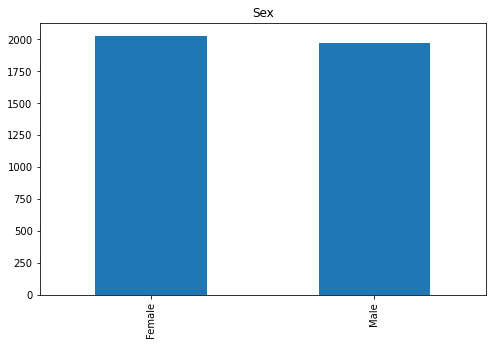

In [11]:
df['sex'].value_counts().plot(kind="bar", legend=False, title='Sex', ylabel='', figsize=(8,5))
plt.show()

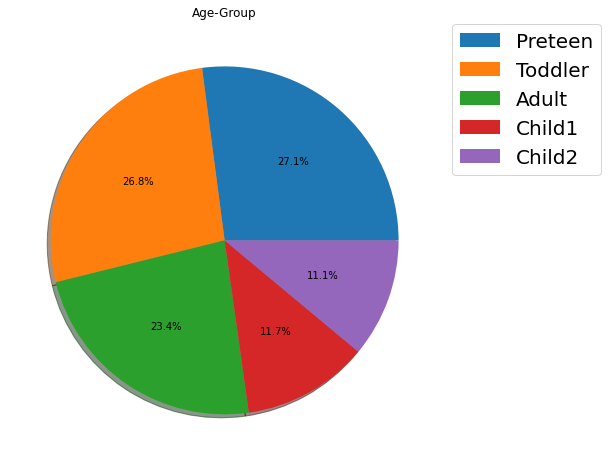

In [12]:
df['age'].value_counts().plot(kind="pie", autopct='%1.1f%%', shadow=True, legend=True, title='Age-Group', ylabel='', labeldistance=None, figsize=(8,8))
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=20)
plt.show()

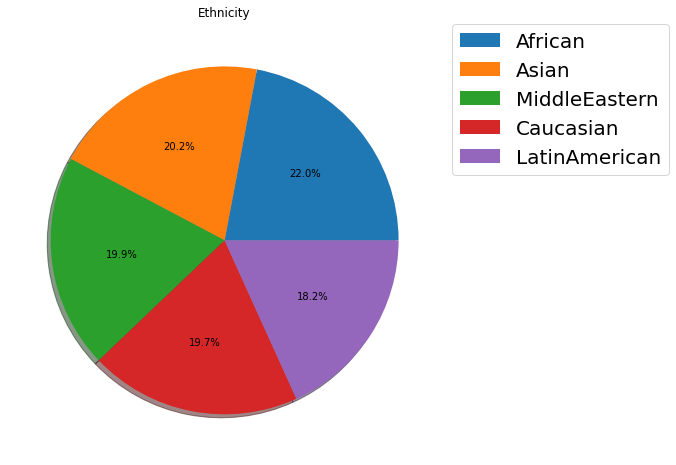

In [13]:
df['ethnicity'].value_counts().plot(kind="pie", autopct='%1.1f%%', shadow=True, legend=True, title='Ethnicity', ylabel='', labeldistance=None, figsize=(8,8))
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=20)
plt.show()

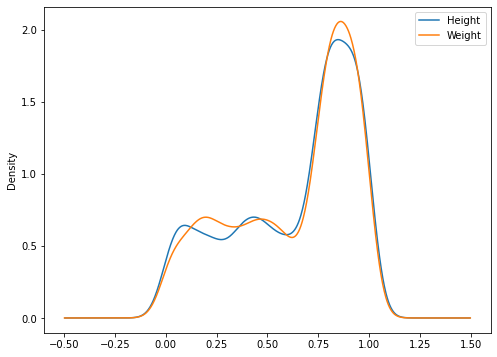

In [14]:
plt.figure(figsize=(8,6))
df['height'].plot.density(label="Height")
df['weight'].plot.density(label="Weight")
plt.legend()

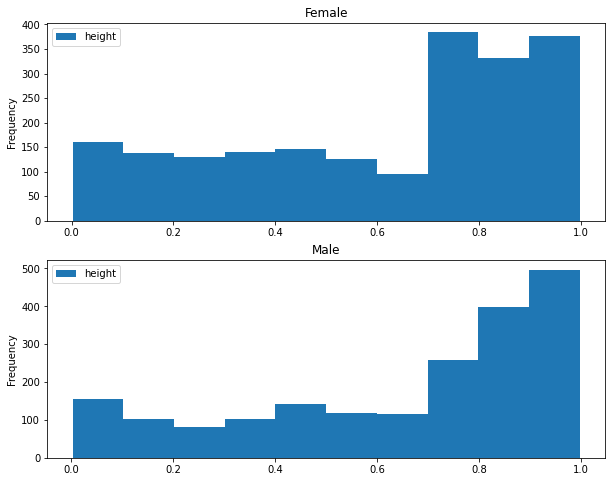

In [15]:
a = df.plot.hist(column=["height"], by="sex", figsize=(10, 8))

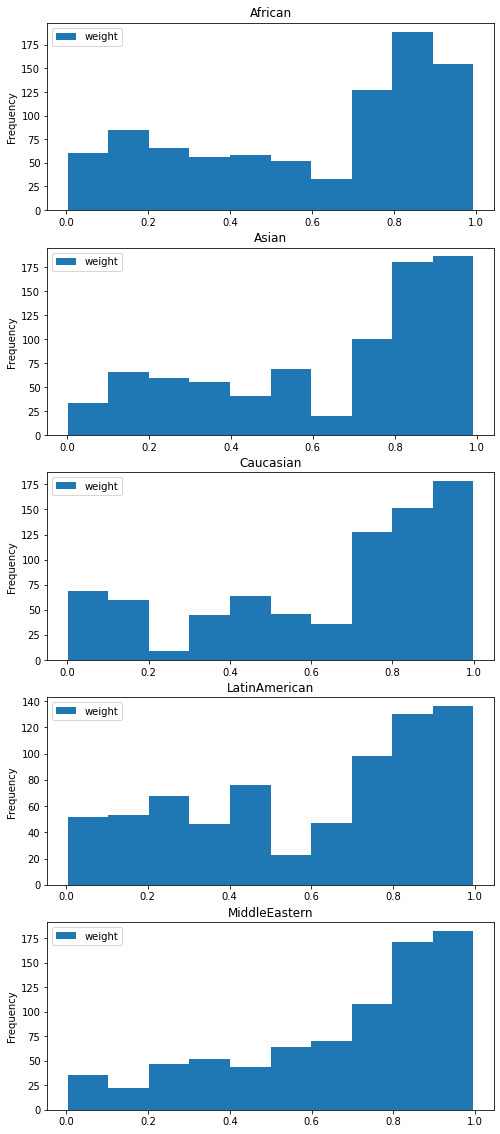

In [16]:
b = df.plot.hist(column=["weight"], by="ethnicity", figsize=(8, 20))